# Importing Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,re,h5py
import time
from tensorflow.keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Activation, Flatten,Conv2D,MaxPooling2D, Dropout,BatchNormalization,ZeroPadding2D,Concatenate,Input
from keras.models import Model
from keras.callbacks import CSVLogger, ReduceLROnPlateau
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define Paths

In [ ]:
PATH = "/content/drive/MyDrive/Malaria/Malaria_Cell_Dataset"
METRICS_PATH="/content/drive/MyDrive/Malaria/Malaria_Cell_Metrics/"
MODEL_NAME="VGG16"
print("PWD", PATH)

PWD /content/drive/MyDrive/Malaria/Malaria_Cell_Dataset


# Define Metrics

In [ ]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [ ]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_negatives / (true_negatives+false_positives + K.epsilon())

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Read Images from drive

In [ ]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [ ]:
data_path = PATH
data_dir_list = sorted_alphanumeric(os.listdir(data_path))
print(data_dir_list)

['Parasitized', 'Uninfected']


In [ ]:

img_data_list = []

for dataset in data_dir_list:
    img_list = sorted_alphanumeric(os.listdir(data_path + '/' + dataset))
    print('Loaded the images of dataset-' + '{}\n'.format(dataset))
    for img in img_list:
        img_path = data_path + '/' + dataset + '/' + img
        img = image.load_img(img_path, target_size=(32,32))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x/255
        img_data_list.append(x)


Loaded the images of dataset-Parasitized

Loaded the images of dataset-Uninfected



In [ ]:
img_data = np.array(img_data_list)
print(img_data.shape)
img_data = np.rollaxis(img_data, 1, 0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)


(27558, 1, 32, 32, 3)
(1, 27558, 32, 32, 3)
(27558, 32, 32, 3)


# Train and Test Data

In [ ]:
num_classes = 2
num_of_samples = img_data.shape[0]
print("sample", num_of_samples)
labels = np.ones((num_of_samples,), dtype='int64')
labels[0:13780] = 1
labels[13780:] = 0
names = ['Parasitized', 'Uninfected']

sample 27558


In [ ]:
from sklearn.utils import shuffle

In [ ]:
Y = np_utils.to_categorical(labels, num_classes)
x, y = shuffle(img_data, Y, random_state=2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


# Model Architecture

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 32, 32, 64)        0         
                                                        

In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-10)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+'.csv', append=True, separator=';')

adam = Adam(lr=0.00006, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.0e-6,amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',f1,specificity,sensitivity])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Model Training

### With Augumentation

In [ ]:
batch_size = 16
data_augmentation = True
epochs = 100

In [ ]:
import time
start_time = time.time()

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[lr_reducer,csv_logger])
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_test, y_test), callbacks=[lr_reducer, csv_logger])

Using real-time data augmentation.


<ipython-input-17-eb7f1dcb9614>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train,


Epoch 1/100
1378/1378 [==============================] - 46s 25ms/step - loss: 0.9147 - accuracy: 0.5718 - f1: 0.5719 - specificity: 0.5719 - sensitivity: 0.5719 - val_loss: 0.7882 - val_accuracy: 0.6138 - val_f1: 0.6143 - val_specificity: 0.6143 - val_sensitivity: 0.6143 - lr: 6.0000e-05
Epoch 2/100
1378/1378 [==============================] - 31s 23ms/step - loss: 0.8131 - accuracy: 0.6044 - f1: 0.6044 - specificity: 0.6044 - sensitivity: 0.6044 - val_loss: 0.8480 - val_accuracy: 0.5942 - val_f1: 0.5943 - val_specificity: 0.5943 - val_sensitivity: 0.5943 - lr: 6.0000e-05
Epoch 3/100
1378/1378 [==============================] - 31s 23ms/step - loss: 0.7510 - accuracy: 0.6332 - f1: 0.6332 - specificity: 0.6332 - sensitivity: 0.6332 - val_loss: 0.9224 - val_accuracy: 0.6108 - val_f1: 0.6109 - val_specificity: 0.6109 - val_sensitivity: 0.6109 - lr: 6.0000e-05
Epoch 4/100
1378/1378 [==============================] - 31s 22ms/step - loss: 0.6886 - accuracy: 0.6719 - f1: 0.6719 - specificit

In [ ]:
print('------------Training time is seconds:%s',time.time()-start_time)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 3395.0517008304596
173/173 [==============================] - 1s 8ms/step - loss: 0.1714 - accuracy: 0.9639 - f1: 0.9641 - specificity: 0.9641 - sensitivity: 0.9641
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[0.9147258996963501, 0.8130682110786438, 0.7510185837745667, 0.6885735988616943, 0.6056084632873535, 0.46884453296661377, 0.32033297419548035, 0.26238709688186646, 0.2290934920310974, 0.204549640417099, 0.1866154819726944, 0.18009865283966064, 0.17355626821517944, 0.17152725160121918, 0.16241121292114258, 0.15779198706150055, 0.15709692239761353, 0.1526939868927002, 0.14748027920722961, 0.14653311669826508, 0.14211232960224152, 0.13805663585662842, 0.13720674812793732, 0.1336636245250702, 0.13676775991916656, 0.126774400472641, 0.12594489753246307, 0.12363671511411667, 0.12473541498184204, 0.12114220857620239, 0.118877544999

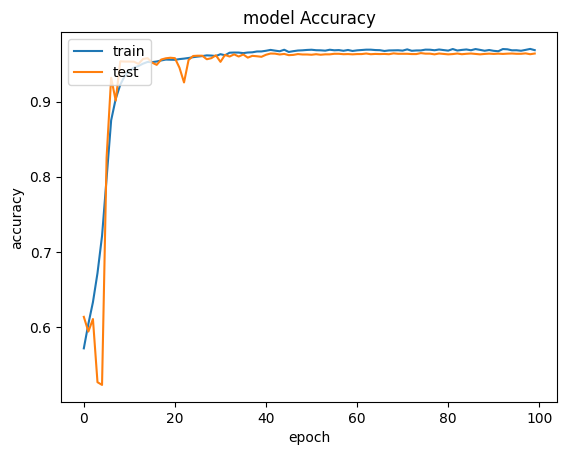

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()

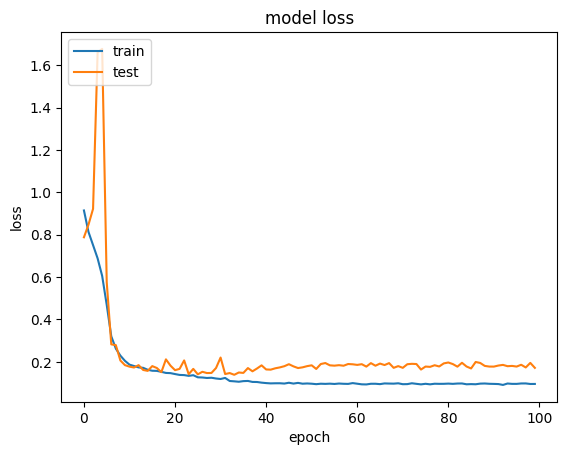

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()


### Without Augumentation

In [ ]:
MODEL_NAME="VGG16_waug"

In [ ]:
batch_size = 16
data_augmentation = False
epochs = 100

In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-10)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+'.csv', append=True, separator=';')

adam = Adam(lr=0.00006, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.0e-6,amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',f1,specificity,sensitivity])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
import time
start_time = time.time()

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[lr_reducer,csv_logger])
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_test, y_test), callbacks=[lr_reducer, csv_logger])

Not using data augmentation.
Epoch 1/100
1378/1378 [==============================] - 42s 22ms/step - loss: 0.9018 - accuracy: 0.5767 - f1: 0.5768 - specificity: 0.5768 - sensitivity: 0.5768 - val_loss: 1.5303 - val_accuracy: 0.5027 - val_f1: 0.5027 - val_specificity: 0.5027 - val_sensitivity: 0.5027 - lr: 6.0000e-05
Epoch 2/100
1378/1378 [==============================] - 27s 20ms/step - loss: 0.7798 - accuracy: 0.6355 - f1: 0.6355 - specificity: 0.6355 - sensitivity: 0.6355 - val_loss: 2.9459 - val_accuracy: 0.4975 - val_f1: 0.4975 - val_specificity: 0.4975 - val_sensitivity: 0.4975 - lr: 6.0000e-05
Epoch 3/100
1378/1378 [==============================] - 29s 21ms/step - loss: 0.6887 - accuracy: 0.6833 - f1: 0.6833 - specificity: 0.6833 - sensitivity: 0.6833 - val_loss: 8.0511 - val_accuracy: 0.4975 - val_f1: 0.4975 - val_specificity: 0.4975 - val_sensitivity: 0.4975 - lr: 6.0000e-05
Epoch 4/100
1378/1378 [==============================] - 28s 20ms/step - loss: 0.5873 - accuracy: 0.7

In [ ]:
print('------------Training time is seconds:%s',time.time()-start_time)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 2922.9697597026825
173/173 [==============================] - 2s 8ms/step - loss: 0.4975 - accuracy: 0.9608 - f1: 0.9610 - specificity: 0.9610 - sensitivity: 0.9610
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[0.9018134474754333, 0.7798058390617371, 0.6886910796165466, 0.5872724056243896, 0.420812726020813, 0.29065611958503723, 0.24460020661354065, 0.21430957317352295, 0.19510988891124725, 0.17986448109149933, 0.1678222119808197, 0.16239877045154572, 0.15394368767738342, 0.15402007102966309, 0.14605693519115448, 0.14028213918209076, 0.13557842373847961, 0.1289108544588089, 0.1258200854063034, 0.12445992231369019, 0.11819586902856827, 0.11048285663127899, 0.1023147702217102, 0.10227698087692261, 0.09963247925043106, 0.09881933778524399, 0.09970814734697342, 0.0886501893401146, 0.09014745056629181, 0.08783555030822754, 0.0880019664

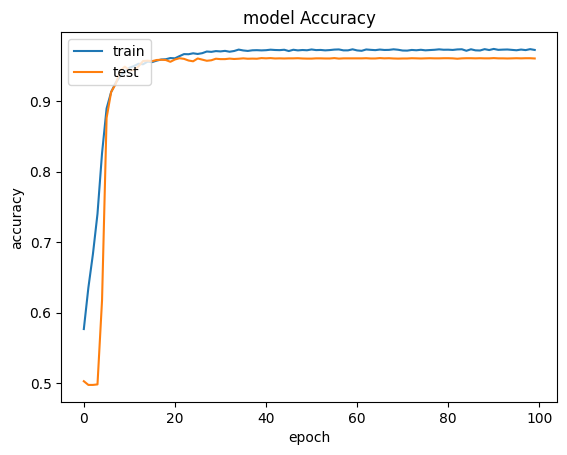

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()

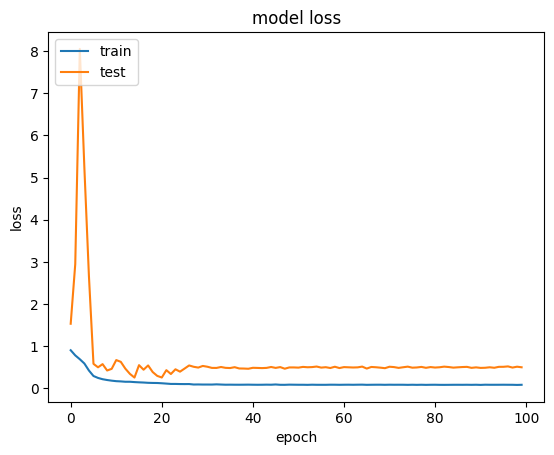

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()
